In [2]:
import warnings
import numpy as np
import pandas as pd
from utils.plots_style import style
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

df = pd.read_csv("./data/preprocessed_data.csv")

warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:488: Warning: Numpy built with MINGW-W64 on Windows 64 bits is experimental, and only available for 
testing. You are advised not to use it for production. 

CRASHES ARE TO BE EXPECTED - PLEASE REPORT THEM TO NUMPY DEVELOPERS


: 

In [ ]:
cols_to_drop = ["fraud_bool", "month", "x1", "x2"]
X = df.drop(columns=cols_to_drop)
y = df["fraud_bool"]

In [ ]:
# Identificar variables categóricas
cat_cols = X.select_dtypes(include="object").columns

# Aplicar one-hot encoding
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [ ]:
# División temporal: entrenamiento de 0–5, testing de 6–7
df_train = df[df["month"] <= 5]
df_test = df[df["month"] >= 6]

X_train = df_train.drop(columns=cols_to_drop)
X_test = df_test.drop(columns=cols_to_drop)

y_train = df_train["fraud_bool"]
y_test = df_test["fraud_bool"]

# One-hot encoding (aplicado a ambos)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Alinear columnas entre train y test
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Guardar los datos escalados y las etiquetas en archivos .npy para su uso posterior
np.save("./trains/X_train_scaled.npy", X_train_scaled)
np.save("./trains/X_test_scaled.npy", X_test_scaled)
np.save("./trains/y_train.npy", y_train.to_numpy())
np.save("./trains/y_test.npy", y_test.to_numpy()) #? Archivo de test independiente para las pruebas

In [ ]:
print(f"Distribución original: {np.bincount(y_train)}")

rs = 42
ss = 0.3

# SMOTE
print("Aplicando SMOTE...")
smote = SMOTE(random_state=rs, sampling_strategy=ss)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
np.save('./trains/X_train_smote.npy', X_train_smote)
np.save('./trains/y_train_smote.npy', y_train_smote)
print("SMOTE:", np.bincount(y_train_smote))

# SMOTEENN
print("Aplicando SMOTE...")
enn = EditedNearestNeighbours(n_neighbors=3, n_jobs=-1)
smoteenn = SMOTEENN(random_state=rs, sampling_strategy=ss, enn=enn)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_scaled, y_train)
np.save('./trains/X_train_smoteenn.npy', X_train_smoteenn)
np.save('./trains/y_train_smoteenn.npy', y_train_smoteenn)
print("SMOTEENN:", np.bincount(y_train_smoteenn))

Distribución original: [749950   8378]
Aplicando SMOTE...
SMOTE: [749950 224985]
Aplicando SMOTE...
SMOTEENN: [692563 224985]


In [ ]:
# Entrenar modelos
clf_normal = LogisticRegression(max_iter=1000, random_state=42)
clf_smote = LogisticRegression(max_iter=1000, random_state=42)
clf_smoteenn = LogisticRegression(max_iter=1000, random_state=42)

clf_normal.fit(X_train_scaled, y_train)
clf_smote.fit(X_train_smote, y_train_smote)
clf_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Predicciones de probabilidad
y_score_normal = clf_normal.predict_proba(X_test_scaled)[:, 1]
y_score_smote = clf_smote.predict_proba(X_test_scaled)[:, 1]
y_score_smoteenn = clf_smoteenn.predict_proba(X_test_scaled)[:, 1]

# Curvas precision-recall
precision_normal, recall_normal, _ = precision_recall_curve(y_test, y_score_normal)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_score_smote)
precision_smoteenn, recall_smoteenn, _ = precision_recall_curve(y_test, y_score_smoteenn)

auc_normal = auc(recall_normal, precision_normal)
auc_smote = auc(recall_smote, precision_smote)
auc_smoteenn = auc(recall_smoteenn, precision_smoteenn)

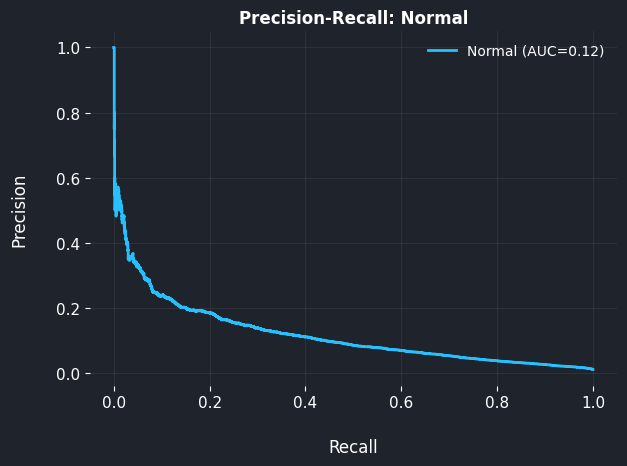

In [ ]:
style()

plt.figure()
plt.plot(recall_normal, precision_normal, label=f'Normal (AUC={auc_normal:.2f})', color='#27c0ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall: Normal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./plots/split/normal.png', dpi=300)
plt.show()
plt.close()

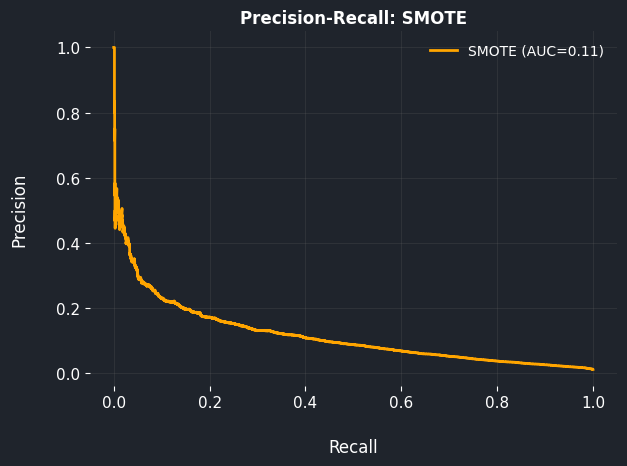

In [ ]:
style()

plt.figure()
plt.plot(recall_smote, precision_smote, label=f'SMOTE (AUC={auc_smote:.2f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall: SMOTE')
plt.legend()
plt.savefig('./plots/split/smote.png')
plt.show()
plt.close()

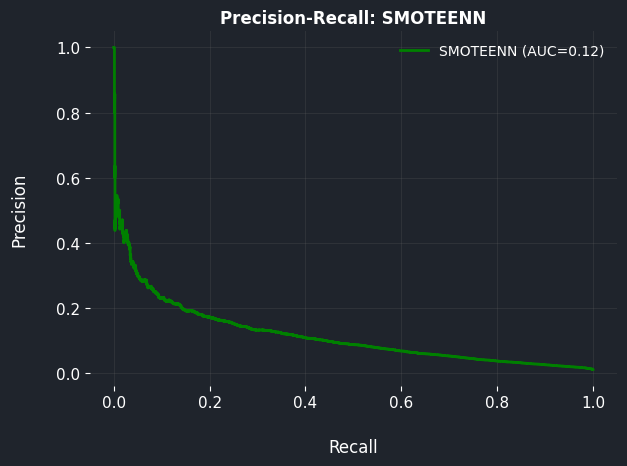

In [ ]:
style()

plt.figure()
plt.plot(recall_smoteenn, precision_smoteenn, label=f'SMOTEENN (AUC={auc_smoteenn:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall: SMOTEENN')
plt.legend()
plt.savefig('./plots/split/smoteenn.png')
plt.show()
plt.close()

In [ ]:
style()

plt.figure()
plt.plot(recall_normal, precision_normal, label=f'Normal (AUC={auc_normal:.2f})')
plt.plot(recall_smote, precision_smote, label=f'SMOTE (AUC={auc_smote:.2f})', color='orange')
plt.plot(recall_smoteenn, precision_smoteenn, label=f'SMOTEENN (AUC={auc_smoteenn:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Comparison')
plt.legend()
plt.savefig('./plots/split/comparison.png')
plt.show()
plt.close()

NameError: name 'plt' is not defined